## Predicting Kickstarter Success

### MSDS 7331-404: Mini Project 1
Travis Deason  
Michael Landrum  
Vanessa Torres  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as scs
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import sys

print(sys.stdout.encoding)

UTF-8


Data Source:

https://www.kaggle.com/kemical/kickstarter-projects

# Create Models

Our data set has a few categorical variables with many levels. So the first thing we need to do is create dummy variables for each level in all the category variables.

** In order to run this notebook, you must first navigate to the src folder within the github directory and run the PYTHON file extract_features.py** 

**This will create the file: '"data_with_dummies_and_class.csv" using "imputed.csv" as a basis**
> **IT TAKES ABOUT 15 MIN TO RUN extract_features.py **

In [2]:
try:
    data= pd.read_csv('data/data_with_dummies_and_class.csv')
except FileNotFoundError:
    data = pd.read_csv("https://s3-us-west-2.amazonaws.com/twisk.us/data_with_dummies_and_class.csv")
    data.to_csv('data/data_with_dummies_and_class.csv', index=False)

In [3]:
data = data[[x for x in data.columns if "Unnamed" not in x]]

In [4]:
unique_cols = list(set(x.split('&')[0] for x in data.columns))

In [5]:
df_nocats = data[[x for x in data.columns if x.split('&')[0] != 'category']]

In [6]:
def p_func(df):
    ooot = {}
    for col in df.columns:
        if '$' in col:
            value = ooot.get(col.split('$')[0], [])
            ooot[col.split('$')[0]] = value + [col.split('$')[1]]
        elif '&' in col:
            value = ooot.get(col.split('&')[0], [])
            ooot[col.split('&')[0]] = value + [col.split('&')[1]]
        else: 
            ooot[col] = ''
    return ooot

In [7]:
for k,v in p_func(df_nocats).items():
    print(k)
    if type(v) is list:
        for i in v:
            print('\t>', i)

id
backers
usd_pledged_real
usd_goal_real
log_goal
duration
success
log_backers
log_usd_goal_real
log_usd_pledged_real
log_duration
isUS
name
	> word_count
	> punc_count
	> caps_count
	> possesive_count
	> noun_count
	> adj_count
	> verb_count
	> preposition_count
	> determinator_count
main_category
	> Publishing
	> Film 
	> Music
	> Food
	> Design
	> Crafts
	> Games
	> Comics
	> Fashion
	> Theater
	> Art
	> Photography
	> Technology
	> Dance
	> Journalism
country
	> GB
	> US
	> CA
	> AU
	> NO
	> IT
	> DE
	> IE
	> MX
	> ES
	> N,0"
	> SE
	> FR
	> NL
	> NZ
	> CH
	> AT
	> DK
	> BE
	> HK
	> LU
	> SG
	> JP
currency
	> GBP
	> USD
	> CAD
	> AUD
	> NOK
	> EUR
	> MXN
	> SEK
	> NZD
	> CHF
	> DKK
	> HKD
	> SGD
	> JPY
length
deadline_month
	> Oct
	> Nov
	> Feb
	> Apr
	> Aug
	> Dec
	> Mar
	> May
	> Jun
	> Sep
	> Jan
	> Jul
launched_month
	> Aug
	> Sep
	> Jan
	> Mar
	> Jul
	> Feb
	> Dec
	> Apr
	> Oct
	> May
	> Nov
	> Jun


In [8]:
dff = df_nocats.drop('''country&N,0"''',axis=1)  ##.dropna()    name$ all have 1 na

name = ['name$word_count','name$punc_count','name$caps_count','name$possesive_count','name$noun_count',
       'name$adj_count','name$verb_count','name$preposition_count','name$determinator_count']
main_cat = ['main_category&Publishing','main_category&Film & Video','main_category&Music',
           'main_category&Food','main_category&Design','main_category&Crafts','main_category&Games',
           'main_category&Comics','main_category&Fashion','main_category&Theater','main_category&Art',
           'main_category&Photography','main_category&Technology','main_category&Dance','main_category&Journalism']

## creating new data frames with just the dummy variables so we can add/subtract them in the future easily
dff_name = dff[name]
dff_main_cat = dff[main_cat]

dff = dff.dropna()

In [9]:
main_features = p_func(dff).keys()
print(len(main_features))

19


## We will run logistic regression on all our features. 

From there we will tweak our model to try and increase our prediction accuracy.

In [10]:
from sklearn import linear_model as lm
from sklearn import svm as svm

In [11]:
## creating arrays for train/test set indices
train_idx = np.random.random(dff.shape[0]) < .8    
test_idx = train_idx == False

In [12]:
## train and test y vector
ytr = dff.iloc[train_idx].pop('success')      
yte = dff.iloc[test_idx].pop('success')
y = dff.pop('success')

In [13]:
## train and test X matrix
Xtr = dff.iloc[train_idx][[col for col in dff.columns if  col != 'success']]
Xte = dff.iloc[test_idx][[col for col in dff.columns if  col != 'success']]
X = dff[[col for col in dff.columns if  col != 'success']]

In [14]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

lr_clf.fit(Xtr,ytr)  # train object
y_hat = lr_clf.predict(Xte) # get test set precitions

acc = mt.accuracy_score(yte,y_hat)
conf = mt.confusion_matrix(yte,y_hat)
print("accuracy", acc )
print("confusion matrix\n",conf)

accuracy 0.642557569043
confusion matrix
 [[48406     0]
 [27102   314]]


### This was not as accurate as we'd like.

We'll remove all the dummy variables we created and see if we can improve it by adding or subtracting them in.

In [15]:
## log regression without any of the categorical variables

data_imp = pd.read_csv('data/imputed.csv')
cat_column = ['name','category','currency','deadline','launched','state','country',"main_category"]

data_imp.drop(cat_column, inplace=True, axis=1)

In [16]:
## creating a function that will output accuracy percentage and confusion matrix for different subsets of features

def log_regression(df):
    train_idx = np.random.random(df.shape[0]) < .8    
    test_idx = train_idx == False

    ytr = df.iloc[train_idx].pop('success')
    yte = df.iloc[test_idx].pop('success')

    Xtr = df.iloc[train_idx][[col for col in df.columns if  col != 'success']]
    Xte = df.iloc[test_idx][[col for col in df.columns if  col != 'success']]

    lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

    lr_clf.fit(Xtr,ytr)  # train object
    y_hat = lr_clf.predict(Xte) # get test set precitions

    acc = mt.accuracy_score(yte,y_hat)
    conf = mt.confusion_matrix(yte,y_hat)
    print("accuracy", acc )
    print("confusion matrix\n",conf)


In [17]:
log_regression(data_imp)

## marginally better, could be due to randomness

accuracy 0.650473980254
confusion matrix
 [[49263     3]
 [26655   348]]


In [18]:
## all numerical variables + word information

df = pd.concat([data_imp,dff_name]).dropna()

log_regression(data_imp)

## marginally better

accuracy 0.651170488851
confusion matrix
 [[48885     3]
 [26342   294]]


In [19]:
## all numerical variables + main_cat or type of project

df = pd.concat([data_imp,dff_main_cat]).dropna()

log_regression(data_imp)

## very marginally better than last

accuracy 0.647592655827
confusion matrix
 [[48996     4]
 [26829   313]]


In [20]:
## all numerical + name + main_cat

df = pd.concat([data_imp,dff_name,dff_main_cat]).dropna()

log_regression(data_imp)

## marginally worse

accuracy 0.652062231049
confusion matrix
 [[48924     5]
 [26273   323]]


### The simplest model.

The next model includes only the amount of backers, the kickstarter's donation goal, and the actual pledge dollars.

In [21]:
df_basic = data_imp[['backers','log_usd_goal_real','log_usd_pledged_real','success']]

log_regression(df_basic)

accuracy 0.985326659642
confusion matrix
 [[48101  1114]
 [    0 26705]]


# Model Advantages

The simple model (98.6% accuracy) with just 3 features vastly outperformed the more complex models, including the model with all the features (64.2%). This is likely the case because of **overfitting**.

It's interesting to see that the simple model had no false negatives whereas the more complex had a few false positives but a lot of false negatives.

# Interpret Feature Importance

In this section we'll just look at the model with 3 features, as it performed the best.

In [22]:
## using the model df_basic model
df = df_basic

train_idx = np.random.random(df.shape[0]) < .8    
test_idx = train_idx == False

ytr = df.iloc[train_idx].pop('success')
yte = df.iloc[test_idx].pop('success')
y = df.pop('success')

Xtr = df.iloc[train_idx][[col for col in df.columns if  col != 'success']]
Xte = df.iloc[test_idx][[col for col in df.columns if  col != 'success']]
X = df[[col for col in df.columns if  col != 'success']]

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

lr_clf.fit(Xtr,ytr)

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])


backers has weight of -0.00011430730654
log_usd_goal_real has weight of -14.9249785047
log_usd_pledged_real has weight of 15.1348867002


In [23]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(Xtr) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(Xtr) # apply to training
X_test_scaled = scl_obj.transform(Xte) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,ytr)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(yte,y_hat)
conf = mt.confusion_matrix(yte,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.983373863396
[[47702  1258]
 [    0 26704]]
log_usd_goal_real has weight of -7.67226947861
backers has weight of -0.0427037475707
log_usd_pledged_real has weight of 15.1664576847


As we know, the weights aren't necessarily interpretable before we normalize, but after we did we can see the amount of money pledged to the kickstarter is about twice as important as the goal amount. The opposing directions makes sense. The more money a kickstarter wants for their goal, the less likely they are to reach their goal. Whereas, the more money they receive, the more likely they are to succeed.

The backers has only a small weight so it's poredictive power is not as strong in our model as you can see from the bar chart below.

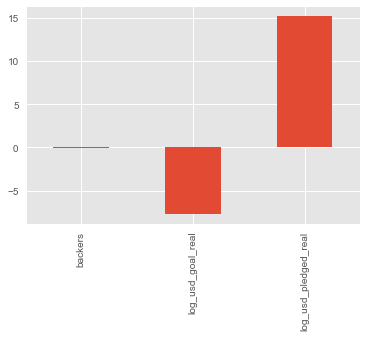

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df[['backers','log_usd_goal_real','log_usd_pledged_real']].columns)
weights.plot(kind='bar')
plt.show()

# Interpret Support Vectors

Below code takes awhile to run.

In [29]:
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC

X_train_scaled = scl_obj.transform(Xtr) # apply to training
X_test_scaled = scl_obj.transform(Xte) 

svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, ytr)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(yte,y_hat)
conf = mt.confusion_matrix(yte,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.988647176993
[[48101   859]
 [    0 26704]]


In [30]:
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(12773, 3)
(12773,)
[6385 6388]


[[ -0.04006366  -6.61427455  12.95619947]]


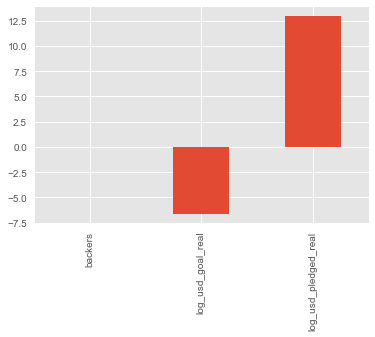

In [31]:
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df[['backers','log_usd_goal_real','log_usd_pledged_real']].columns)
weights.plot(kind='bar')

In [34]:
# make a dataframe of the training data
df_tested_on = df.iloc[train_idx] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support.loc[:,'success'] = y[svm_clf.support_] # add back in the 'success' Column to the pandas dataframe
df.loc[:,'success'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12773 entries, 146 to 378623
Data columns (total 4 columns):
backers                 12773 non-null int64
log_usd_goal_real       12773 non-null float64
log_usd_pledged_real    12773 non-null float64
success                 446 non-null float64
dtypes: float64(3), int64(1)
memory usage: 498.9 KB


/Users/michael/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


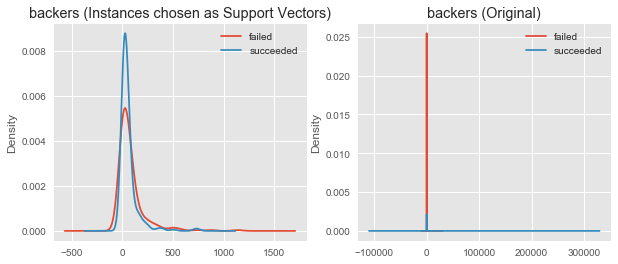

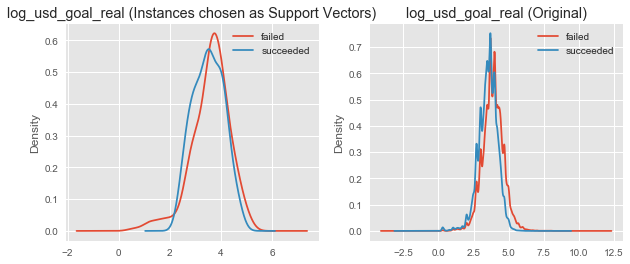

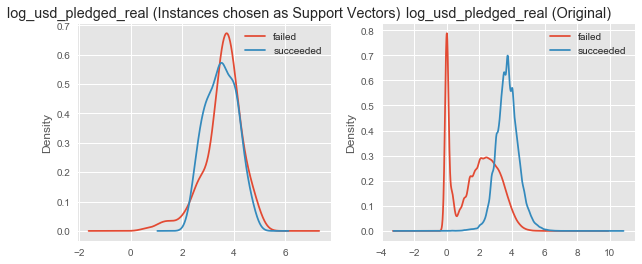

In [36]:
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['success'])
df_grouped = df.groupby(['success'])

# plot KDE of Different variables
vars_to_plot = ['backers','log_usd_goal_real','log_usd_pledged_real']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['failed','succeeded'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['failed','succeeded'])
    plt.title(v+' (Original)')
